In [4]:
# import torch
# def cosine_sim(x1, x2, dim=1, eps=1e-8):
#     ip = torch.mm(x1, x2.t())
#     w1 = torch.norm(x1, 2, dim)
#     w2 = torch.norm(x2, 2, dim)
#     return ip / torch.ger(w1,w2).clamp(min=eps)
import torch.nn as nn

nn.NLLLoss?

## **ArcFace 실습에 필요한 파이썬 라이브러리를 불러옵니다.** 

In [1]:
# import metrics
import os
import math
import random
import time
from PIL import Image

import torch # pytorch의 tensor와 그와 관련된 기본 연산 등을 지원
import torch.nn as nn # 여러 딥러닝 layer와 loss, 함수 등을 클래스 형태로 지원
import torch.nn.functional as F # 여러 loss, 함수 등을 function 형태로 지원
import torch.optim as optim # 여러 optimizer를 지원

from torchvision.datasets import ImageFolder # (img, label) 형태의 데이터셋 구성을 쉽게 할 수 있도록 지원
import torchvision.transforms as T # 이미지 전처리를 지원
import torchvision.utils # 여러가지 편리한 기능을 지원 (ex. grid 이미지 만들기 등)
import torchvision.models as models # VGG, ResNet 등을 바로 로드할 수 있도록 지원
from torch.utils.data import DataLoader # 데이터 로더를 쉽게 만들 수 있도록 지원

from torch.utils.tensorboard import SummaryWriter # Tensorflow의 Tensorboard를 지원

# GPU 선택
os.environ['CUDA_VISIBLE_DEVICES']='1'

/home/sktkdgus94/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sktkdgus94/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sktkdgus94/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sktkdgus94/anaconda3/lib/python3.6/site-pac

## Training에 사용될 데이터를 불러옵니다.
  
이번 실습에서 사용할 데이터셋은 __CASIA-Webface__ 데이터셋입니다.
  
  
- 총 ID 개수 : 10575  
- 총 이미지 개수 : 494414
- ID 당 최소 이미지 개수 : 2
- ID 당 최대 이미지 개수 : 804
- ID 당 평균 이미지 개수 : 46.75
- 이미지 크기 : 250 x 250

In [2]:
def data_loader(root, batch_size, resize, crop, gray_scale, shuffle):
    '''
    목적 : (image, label) 을 반복적으로 로드해주는 데이터 로더 만들기
    
    인자:
    root : 이미지의 루트 디렉토리
    batck_size : 배치 사이즈
    resize : 이미지 resize 사이즈
    crop : 이미지 crop 사이즈
    gray_scale : 흑백 변환 여부
    shuffle : 무작위 섞음 여부
    '''
    
    ''' Step 1. 이미지 전처리 '''
    trans_list = []
    
    if gray_scale:
        trans_list += [T.Grayscale(num_output_channels=1)]
        
    trans_list += [T.Resize((resize, resize)),
                   T.RandomCrop((crop, crop)),
                   T.ToTensor()]
    
    if gray_scale:
        trans_list += [T.Normalize(mean=(0.5,), std=(0.5,))]
    else:
        trans_list += [T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]
        
    # Compose에 원하는 전처리의 list를 전달한다.
    transformer = T.Compose(trans_list)
    
    ''' Step 2. Dataset 구성하기 '''
    # root - class directory - images 구조에서 (img, label) 꼴을 로드하는 데이터 로더의 구현에 사용 가능
    dataset = ImageFolder(root, transform=transformer)
    
    ''' Step 3. Data loader 만들기'''
    dloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    # Tip : 여기서 data loader 뿐만 아니라 class의 개수, data 전체 개수를 같이 반환하면 나중에 편하다.
    return dloader, len(dataset.classes), len(dataset)

## 각 클래스의 데이터를 확인합니다.

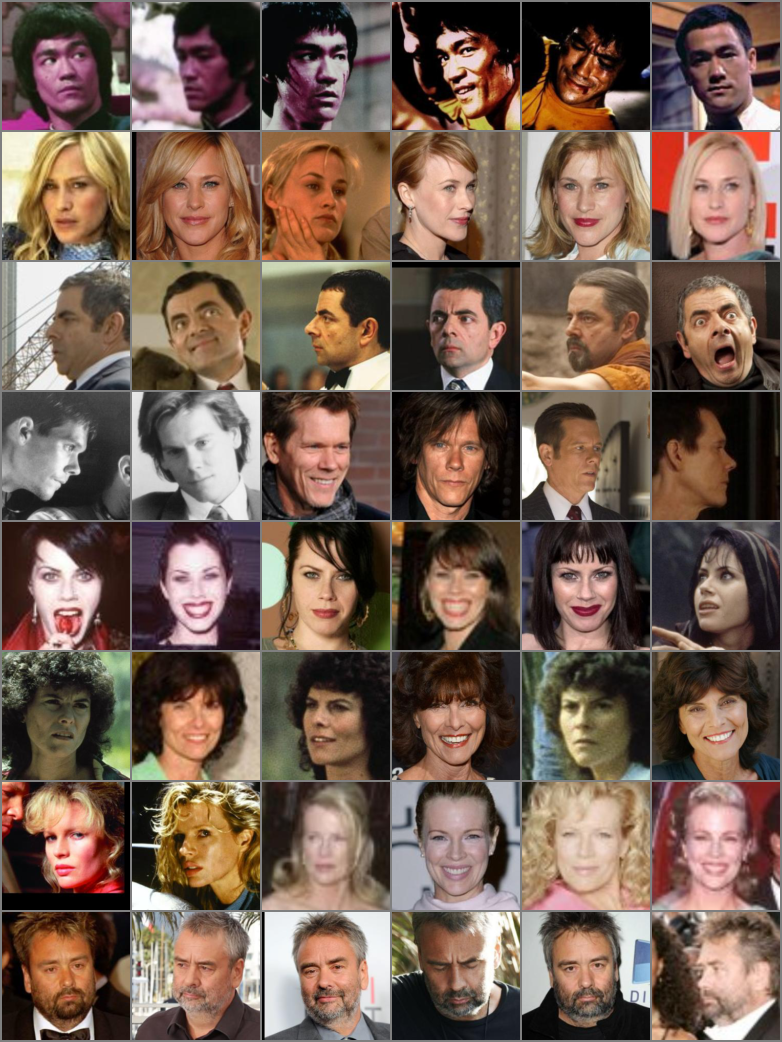

In [4]:
def visualize_data(trn_data_dir, img_per_class=6):    
    ''' 각 row에 같은 class의 이미지가 있는 이미지 만들기 '''
    temp_dloader, _, _ = data_loader(root=trn_data_dir, 
                                     batch_size=1024, 
                                     resize=128, 
                                     crop=128, 
                                     gray_scale=False,
                                     shuffle=False) # Shuffle을 하지 않았다. 클래스 순서대로 로드.
    
    # 한 번 load 할 때는 iter에 넣어서 사용 가능
    img, label = iter(temp_dloader).next()
    
    # 로드한 이미지들의 class 범위
    min_cls = torch.min(label)
    max_cls = torch.max(label)
    
    result_img = []
    
    for num_cls in range(min_cls, max_cls):
        # load한 이미지중 각 class의 첫 번째 이미지의 index를 찾아서 index ~ index + 6 까지의 이미지 저장
        first_idx = (label == num_cls).nonzero()[0]
        result_img.append(img[first_idx:first_idx + img_per_class])
        
    # list에 있는 이미지들을 묶어서 tensor로 변경
    result_img = torch.cat(result_img, dim=0)
    
    # tensor를 이미지로 변환
    grid_img = torchvision.utils.make_grid(result_img, nrow=img_per_class, padding=2)
    
    # denorm -> permute (PIL Image의 형태에 맞게) -> CPU로 전달
    ndarr = (((grid_img / 2) + 0.5) * 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    img = Image.fromarray(ndarr)
    return img

visualize_data(trn_data_dir='../data/CASIA-WebFace', img_per_class=6)

### ArcFace

![Architecture](img/arcface.PNG)
![Loss function](img/arc_loss.PNG)


## ArcFace의 모델을 구현합니다.
  
- Backbone model은 __ResNet-50__ 모델을 사용하도록 하겠습니다.
  
  
# 절차
1. ArcFace의 핵심에 해당하는 마지막 fc 의 class 구현
2. Pytorch에서 제공해주는 ResNet 을 불러와서 필요한 부분 변경하기
3. 1과 2에서 정의된 모듈을 사용하여 ArcFace network 구현

In [3]:
class ArcMarginProduct(nn.Module):
    '''
    목적 : Arc marin 을 포함한 last fc layer의 구현
    
    인자 :
    in_features : feature의 dimension = 512
    out_features : class 개수 = 10535
    '''
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        # fc의 parameter 만들기
        self.weight = torch.nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        '''
        Step 1. cos(theta + m) 계산하기
        '''
        # cosine : cos(theta)
        # [N, in_features] * [in_features, out_features] = [N, out_features] / normalize-> cos dist == cos
        # linear(x, W) = x * W^T = [N, in_features] * [in_features, out_features] = [N, out_features]
        # F.normalize는 디폴트가 dim = 1 (줄이고자하는 dimension)
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        
        # c^2 + s^2 = 1 
        sine = torch.sqrt((1.00000001 - torch.pow(cosine, 2)).clamp(0, 1))
        
        # cos(theta + m) = cos(theta) * cos(m) - sin(theta) * sin(m)
        phi = cosine * self.cos_m - sine * self.sin_m
        
        '''
        Step 2. cos(theta + m) 에서 dim=1에 대해 y_i에 해당하는 부분만 남기고 나머지는 cos(theta)로 되돌리기 
        '''
        one_hot = torch.zeros(cosine.size()).to(dev)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        
        '''
        Step 3. 이 output이 softmax -> cross entropy loss로 흘러가면 된다.
        '''
        return output

class FeatureNet_50(nn.Module):
    '''
    목적 : ResNet-50을 이용한 backbone network(feature extractor) 구현 
    
    인자 :
    feature_dim : feature의 dimension
    gray_scale : 이미지를 gray scale로 받았는지 여부
    '''
    def __init__(self, feature_dim, gray_scale=True):
        super(FeatureNet_50, self).__init__()
        # Pytorch에서 이미 구현되어 있는 resnet-50 불러오기
        resnet = models.resnet50(pretrained=False)
        
        # 이런식으로 불러온 resnet을 조건에 맞게 변경할 수 있다.
        if gray_scale:
            resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            
        # resnet의 마지막 conv block까지만 남기고 나머지 부분 잘라내기
        self.backbone = nn.Sequential(* list(resnet.children())[0:-2])
        
        # resnet의 마지막 conv block 뒤쪽으로 새로 붙을 layer 들
        self.bn_4 = nn.BatchNorm2d(2048)
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(2048 * 4 * 4, feature_dim)
        self.bn_5 = nn.BatchNorm1d(feature_dim)
        
    def forward(self, x):
        out = self.backbone(x)
        out = self.bn_4(out)
        out = self.dropout(out)
        
        # FC layer를 지나기 전에는 reshape 과정이 필요하다.
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.bn_5(out)
        return out

class ArcFaceNet(nn.Module):
    '''
    ArcMarginProduct와 FeatureNet-50 을 결합한 ArcFace 모델의 구현
    '''
    def __init__(self, feature_dim, cls_num, gray_scale=True):
        super(ArcFaceNet, self).__init__()
        self.feature_net = FeatureNet_50(feature_dim, gray_scale=gray_scale)
        self.classifier = ArcMarginProduct(feature_dim, cls_num)

    # 끝까지 Forward 하여 logit을 return
    def forward(self, x, label):
        out = self.feature_net(x)
        out = self.classifier(out, label)
        return out
    
    # Feature만 return
    def extract_feature(self, x):
        out = self.feature_net(x)
        return out


## 학습에 사용될 유틸리티 함수들을 구현합니다.

In [4]:
def cos_dist(x1, x2):
    '''
    목적 : 벡터 x1, x2 사이의 Cosine similary를 계산
    
    인자 :
    x1, x2 : 두 벡터
    '''
    return torch.sum(x1 * x2) / (torch.norm(x1) * torch.norm(x2))

def fixed_img_list(lfw_pair_text, test_num):
    '''
    목적 : 중간 테스트 때 계속 사용될 고정 test 이미지 리스트 생성
    
    인자:
    lfw_pair_text : pair가 만들어진 이미지 경로
    test_num : 테스트에 사용할 pair 개수
    '''
    f = open(lfw_pair_text, 'r')
    lines = []

    while True:
        line = f.readline()
        if not line:
            break
        lines.append(line)
    f.close()

    random.shuffle(lines)
    lines = lines[:test_num]
    return lines

def verification(net, pair_list, tst_data_dir, img_size, gray_scale=True):
    '''
    목적 : Face verification 테스트 수행
    
    인자:
    net : 네트워크
    pair_list : pair가 만들어진 이미지 경로의 리스트
    tst_data_dir : 테스트 이미지가 있는 루트 디렉토리
    img_size : 테스트에 사용할 이미지 사이즈
    gray_scale : 흑백으로 변환 여부
    '''
    
    '''
    STEP 1 : 주어진 이미지 pair에서 feature 를 뽑아 similarity, label 리스트 생성
    '''
    similarities = []
    labels = []

    # 이미지 전처리
    trans_list = []
    
    if gray_scale:
        trans_list += [T.Grayscale(num_output_channels=1)]
        
    trans_list += [T.CenterCrop((178, 178)),
                   T.Resize((img_size, img_size)),
                   T.ToTensor()]
    
    if gray_scale:
        trans_list += [T.Normalize(mean=(0.5,), std=(0.5,))]
    else:
        trans_list += [T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]
    t = T.Compose(trans_list)

    # 주어진 모든 이미지 pair에 대해 similarity 계산
    net.eval()
    with torch.no_grad(): # Test 때 GPU를 사용할 경우 메모리 절약을 위해 torch.no_grad() 내에서 하는 것이 좋다.
        for idx, pair in enumerate(pair_list):
            # Read paired images
            path_1, path_2, label = pair.split(' ')
            img_1 = t(Image.open(os.path.join(tst_data_dir, path_1))).unsqueeze(dim=0).to(dev)
            img_2 = t(Image.open(os.path.join(tst_data_dir, path_2))).unsqueeze(dim=0).to(dev)
            imgs = torch.cat((img_1, img_2), dim=0)

            # Extract feature and save
            features = net.extract_feature(imgs).cpu()
            similarities.append(cos_dist(features[0], features[1]))
            labels.append(int(label))
            
    '''
    STEP 2 : similarity와 label로 verification accuracy 측정
    '''
    best_accr = 0.0
    best_th = 0.0

    # 각 similarity들이 threshold의 후보가 된다
    list_th = similarities
    
    # list -> tensor
    similarities = torch.stack(similarities, dim=0)
    labels = torch.ByteTensor(labels)

    # 각 threshold 후보에 대해 best accuracy를 측정
    for i, th in enumerate(list_th):
        pred = (similarities >= th)
        correct = (pred == labels)
        accr = torch.sum(correct).item() / correct.size(0)

        if accr > best_accr:
            best_accr = accr
            best_th = th.item()

    return best_accr, best_th

-

## 학습에 필요한 Hyperparameter 설정하기

In [5]:
# 각종 경로
trn_data_dir = '../data/CASIA-WebFace'
tst_data_dir = '../data/lfw'
lfw_pair_text = 'lfw_test_part.txt'
log_dir = 'log/arcface'
weight_dir = 'weight/arcface'

# 데이터 관련 세팅
batch_size = 16
resize = 128
crop = 128
gray_scale = True

# Hyperparameter
feature_dim = 512
lr = 0.1  # initial learning rate
lr_step = 10000
decay_ratio = 0.1
weight_decay = 5e-4

# Setting
max_epoch = 200
save_every = 10000
record_every = 1000
display_every = 1000
test_num = 500

# GPU가 있을 경우 연산을 GPU에서 하고 없을 경우 CPU에서 진행
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

# 디렉토리가 없을 시 생성
if not os.path.exists(weight_dir):
    os.makedirs(weight_dir)

## 학습에 필요한 객체들을 선언합니다.

In [6]:
# 데이터 로더
dloader, cls_num, data_num = data_loader(root=trn_data_dir,
                                         batch_size=batch_size,
                                         resize=resize,
                                         crop=crop,
                                         gray_scale=gray_scale,
                                         shuffle=True)
# 네트워크
net = ArcFaceNet(feature_dim=feature_dim, 
                 cls_num=cls_num, 
                 gray_scale=gray_scale).to(dev)

# optimizer 및 learning rate scheduler
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=decay_ratio)

# loss function
criterion = nn.CrossEntropyLoss()

# log 기록
writer = SummaryWriter(log_dir)

In [12]:
net.eval()
net.load_state_dict(torch.load('weight/arcface_pretrained/ckpt_280000.pkl'))
fixed_test_pair = fixed_img_list(lfw_pair_text, test_num)
accr, th = verification(net, fixed_test_pair, tst_data_dir, resize, gray_scale)
print(accr, th)

0.982 0.2893460690975189


## 학습을 시작합니다.

In [12]:
# 현재 epoch와 현재까지의 전체 iteration
epoch = 0
total_iters = 0

# Best accuracy와 그 때의 iteration
best_accr = 0.0
best_iter = 0

# 중간 test에 사용할 고정 테스트 이미지 pair
fixed_test_pair = fixed_img_list(lfw_pair_text, test_num)

# 1 epoch 당 iterationㅇ,; 수
iter_per_epoch = (data_num // batch_size) + 1

# Training 시작
while(epoch < max_epoch):
    for iters, (img, label) in enumerate(dloader):
        # 매 iteration 마다 필요한 preprocess
        net.train()
        scheduler.step()
        optimizer.zero_grad()

        # 이미지, label을 로드하여 forward
        img, label = img.to(dev), label.to(dev)
        logit = net(img, label)
        loss = criterion(logit, label)

        # Bacpropagation 및 update
        loss.backward()
        optimizer.step()

        # 현재의 총 iteration 계산
        total_iters = (iter_per_epoch * epoch) + iters

        # 지금이 Record를 해야할 iteration일 경우
        if total_iters % record_every == 0:
            net.eval()
            
            # 중간 테스트
            accr, th = verification(net, fixed_test_pair, tst_data_dir, resize, gray_scale)

            # Tensorboard에 기록
            writer.add_scalar('loss', loss.item(), total_iters)
            writer.add_scalar('accr', accr, total_iters)
            writer.add_scalar('lr', scheduler.get_lr()[0], total_iters)
            
            # Best accuracy 체크
            if accr > best_accr:
                best_accr = accr
                best_iter = total_iters

        # 지금이 중간 결과를 보여줘야할 iteration일 경우
        if total_iters % display_every == 0:
            print(time.strftime("%Y-%m-%d %H:%M" + ":00"))
            print('* [Total iters : %d (epoch : %d / iter : %d)] => loss : %f, best_accr : %f(iter : %d)\n'\
                  %(total_iters, epoch, iters, loss.item(), best_accr, best_iter))

        # 지금이 모델을 저장해야할 iteration일 경우
        if total_iters % save_every == 0:
            file_name = 'ckpt_' + str(total_iters) + '.pkl'
            path_ckpt = os.path.join(weight_dir, file_name)
            torch.save(net.state_dict(), path_ckpt)

    # 모든 데이터를 다 돌면 epoch 증가
    epoch = epoch + 1

2019-08-07 16:15:00
* [Total iters : 0 (epoch : 0 / iter : 0)] => loss : 24.444355, best_accr : 0.572000(iter : 0)



KeyboardInterrupt: 

In [ ]:
accr, th = verification(net, fixed_test_pair, tst_data_dir, resize, gray_scale)

## Feature들이 어떻게 학습 되었는지 T-sne를 통해 확인합니다.

In [13]:
# Tensorboard writer
writer = SummaryWriter('log/arcface_pretrained', filename_suffix='dummy')

# model에 weight를 로드합니다.
load_iters = 200000
ckpt_name = 'ckpt_' + str(load_iters) + '.pkl'
ckpt_path = os.path.join('weight/arcface_pretrained', ckpt_name)
net.load_state_dict(torch.load(ckpt_path))

# T-sne visualization
tsne_visualization(net=net, 
                   tsne_writer=writer, 
                   iters=load_iters,
                   tst_data_dir=tst_data_dir, 
                   img_size=128, 
                   cls_num=20, 
                   min_data_num=30, 
                   max_data_num=100)